ModuleNotFoundError: No module named 'xlsxwriter'

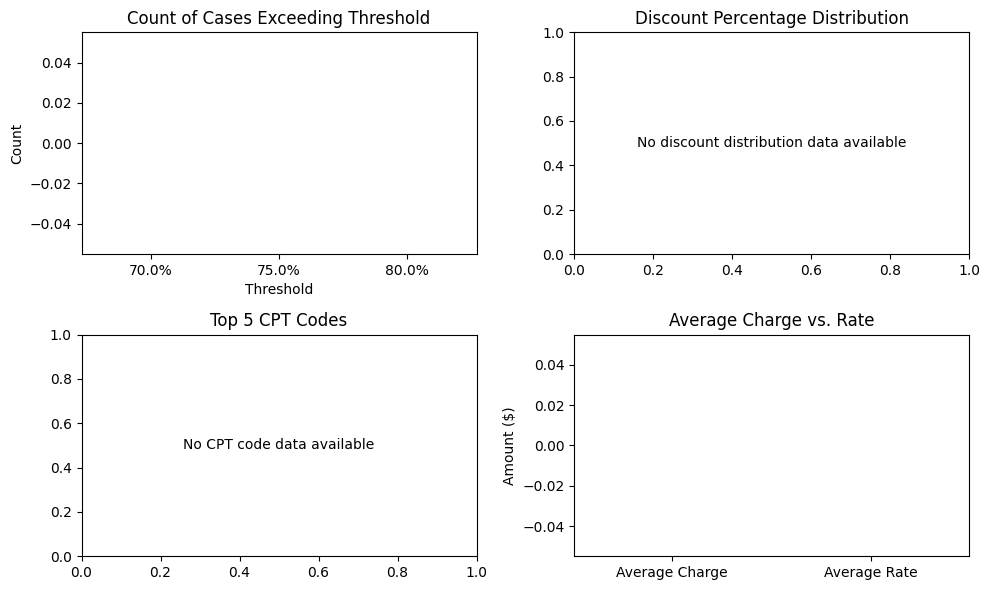

In [2]:
import json
import os
import glob
from pathlib import Path
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

def analyze_rates(directory_path, thresholds=[0.7, 0.75, 0.8]):
    """
    Analyzes rate information in JSON files to find cases where 
    the calculated rate exceeds specified percentages of the charged amount.
    
    Args:
        directory_path: Path to the directory containing JSON files
        thresholds: List of percentage thresholds to check (as decimals)
    
    Returns:
        A dictionary containing analysis results
    """
    # Initialize results
    results = {
        "total_files": 0,
        "files_with_rates": 0,
        "total_service_lines": 0,
        "threshold_analysis": {threshold: [] for threshold in thresholds},
        "summary": {threshold: {"count": 0, "percentage": 0} for threshold in thresholds},
        "average_charge": 0,
        "average_rate": 0,
        "average_discount": 0,
        "max_discount": 0,
        "min_discount": 100,
        "network_status_counts": {},
        "cpt_code_frequency": {},
        "modifier_frequency": {},
        "detail_records": []
    }
    
    # Get all JSON files in directory
    json_files = glob.glob(os.path.join(directory_path, "*.json"))
    results["total_files"] = len(json_files)
    
    # Process each file
    all_charges = []
    all_rates = []
    all_discounts = []
    
    for file_path in json_files:
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            # Skip files without assigned rates
            if "assigned_rates" not in data or not data["assigned_rates"]:
                continue
                
            results["files_with_rates"] += 1
            
            # Extract provider network status if available
            network_status = "Unknown"
            if "provider_details" in data and data["provider_details"].get("Billing_Address", {}).get("State"):
                provider_state = data["provider_details"]["Billing_Address"]["State"]
                results["network_status_counts"][provider_state] = results["network_status_counts"].get(provider_state, 0) + 1
            
            # Get service lines and assigned rates
            service_lines = data.get("service_lines", [])
            assigned_rates = data.get("assigned_rates", [])
            
            results["total_service_lines"] += len(service_lines)
            
            # Match service lines with assigned rates
            for i, service_line in enumerate(service_lines):
                if i >= len(assigned_rates):
                    continue
                    
                cpt_code = service_line.get("cpt_code", "")
                modifiers = service_line.get("modifiers", [])
                charge_amount = float(service_line.get("charge_amount", 0))
                
                # Update CPT code frequency
                results["cpt_code_frequency"][cpt_code] = results["cpt_code_frequency"].get(cpt_code, 0) + 1
                
                # Update modifier frequency
                for modifier in modifiers:
                    results["modifier_frequency"][modifier] = results["modifier_frequency"].get(modifier, 0) + 1
                
                # Get assigned rate
                assigned_rate = float(assigned_rates[i].get("assigned_rate", 0))
                
                # Skip if charge or rate is zero
                if charge_amount == 0 or assigned_rate == 0:
                    continue
                
                # Calculate discount
                discount_percent = (charge_amount - assigned_rate) / charge_amount * 100
                
                # Update min/max discount
                results["max_discount"] = max(results["max_discount"], discount_percent)
                results["min_discount"] = min(results["min_discount"], discount_percent)
                
                # Add to averages lists
                all_charges.append(charge_amount)
                all_rates.append(assigned_rate)
                all_discounts.append(discount_percent)
                
                # Add detail record
                detail = {
                    "filename": os.path.basename(file_path),
                    "patient_name": data.get("patient_info", {}).get("patient_name", ""),
                    "order_id": data.get("Order_ID", ""),
                    "cpt_code": cpt_code,
                    "modifiers": modifiers,
                    "charge_amount": charge_amount,
                    "assigned_rate": assigned_rate,
                    "discount_percent": discount_percent,
                    "rate_source": assigned_rates[i].get("rate_source", ""),
                    "is_bundled": assigned_rates[i].get("is_bundled", False),
                    "date_of_service": service_line.get("date_of_service", "")
                }
                results["detail_records"].append(detail)
                
                # Check thresholds
                for threshold in thresholds:
                    threshold_amount = charge_amount * threshold
                    
                    if assigned_rate > threshold_amount:
                        results["threshold_analysis"][threshold].append({
                            "filename": os.path.basename(file_path),
                            "patient_name": data.get("patient_info", {}).get("patient_name", ""),
                            "order_id": data.get("Order_ID", ""),
                            "cpt_code": cpt_code,
                            "modifiers": modifiers,
                            "charge_amount": charge_amount,
                            "threshold_amount": threshold_amount,
                            "assigned_rate": assigned_rate,
                            "difference": assigned_rate - threshold_amount,
                            "date_of_service": service_line.get("date_of_service", "")
                        })
                        results["summary"][threshold]["count"] += 1
        
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
    
    # Calculate averages
    if all_charges:
        results["average_charge"] = sum(all_charges) / len(all_charges)
    
    if all_rates:
        results["average_rate"] = sum(all_rates) / len(all_rates)
    
    if all_discounts:
        results["average_discount"] = sum(all_discounts) / len(all_discounts)
    
    # Calculate percentages for thresholds
    total_lines_with_rates = len(results["detail_records"])
    for threshold in thresholds:
        count = results["summary"][threshold]["count"]
        if total_lines_with_rates > 0:
            results["summary"][threshold]["percentage"] = (count / total_lines_with_rates) * 100
    
    # Get top CPT codes and modifiers
    results["top_cpt_codes"] = dict(sorted(results["cpt_code_frequency"].items(), 
                                           key=lambda x: x[1], reverse=True)[:10])
    
    results["top_modifiers"] = dict(sorted(results["modifier_frequency"].items(), 
                                          key=lambda x: x[1], reverse=True)[:5])
    
    # Generate additional metrics
    if all_charges and all_rates:
        # Calculate distribution of discount percentages
        discount_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        discount_counts = [0] * (len(discount_bins) - 1)
        
        for discount in all_discounts:
            for i in range(len(discount_bins) - 1):
                if discount_bins[i] <= discount < discount_bins[i+1]:
                    discount_counts[i] += 1
                    break
        
        results["discount_distribution"] = {
            "bins": [f"{discount_bins[i]}-{discount_bins[i+1]}%" for i in range(len(discount_bins) - 1)],
            "counts": discount_counts
        }
    
    return results

def generate_report(results, output_path=None):
    """
    Generate a comprehensive report based on analysis results.
    
    Args:
        results: Results dictionary from analyze_rates()
        output_path: Path to save the report (if None, prints to console)
    
    Returns:
        Report text
    """
    report = []
    report.append("=" * 80)
    report.append("RATE ANALYSIS REPORT")
    report.append(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append("=" * 80)
    
    report.append("\nSUMMARY STATISTICS:")
    report.append(f"Total files analyzed: {results['total_files']}")
    report.append(f"Files with rate information: {results['files_with_rates']}")
    report.append(f"Total service lines: {results['total_service_lines']}")
    report.append(f"Lines with rate information: {len(results['detail_records'])}")
    
    report.append(f"\nAverage charged amount: ${results['average_charge']:.2f}")
    report.append(f"Average assigned rate: ${results['average_rate']:.2f}")
    report.append(f"Average discount percentage: {results['average_discount']:.2f}%")
    report.append(f"Maximum discount: {results['max_discount']:.2f}%")
    report.append(f"Minimum discount: {results['min_discount']:.2f}%")
    
    report.append("\nTHRESHOLD ANALYSIS:")
    for threshold in sorted(results['summary'].keys()):
        count = results['summary'][threshold]['count']
        percentage = results['summary'][threshold]['percentage']
        report.append(f"Cases where rate exceeds {threshold*100}% of charge: {count} ({percentage:.2f}% of lines)")
    
    report.append("\nTOP CPT CODES:")
    for cpt, count in results['top_cpt_codes'].items():
        report.append(f"  {cpt}: {count} occurrences")
    
    report.append("\nTOP MODIFIERS:")
    for modifier, count in results['top_modifiers'].items():
        report.append(f"  {modifier}: {count} occurrences")
    
    report.append("\nPROVIDER STATE DISTRIBUTION:")
    for state, count in results['network_status_counts'].items():
        report.append(f"  {state}: {count} files")
    
    # Only include discount distribution if it exists in the results
    if 'discount_distribution' in results:
        report.append("\nDISCOUNT DISTRIBUTION:")
        for i, bin_range in enumerate(results['discount_distribution']['bins']):
            count = results['discount_distribution']['counts'][i]
            report.append(f"  {bin_range}: {count} lines")
    
    # Detailed threshold reports
    for threshold in sorted(results['threshold_analysis'].keys()):
        threshold_cases = results['threshold_analysis'][threshold]
        if threshold_cases:
            report.append(f"\nDETAILED RESULTS FOR {threshold*100}% THRESHOLD:")
            report.append("-" * 80)
            for case in threshold_cases[:20]:  # Limit to first 20 for readability
                report.append(f"  File: {case['filename']}")
                report.append(f"  Patient: {case['patient_name']}")
                report.append(f"  Order ID: {case['order_id']}")
                report.append(f"  CPT Code: {case['cpt_code']} (Modifiers: {', '.join(case['modifiers']) if case['modifiers'] else 'None'})")
                report.append(f"  Charge Amount: ${case['charge_amount']:.2f}")
                report.append(f"  Threshold Amount ({threshold*100}%): ${case['threshold_amount']:.2f}")
                report.append(f"  Assigned Rate: ${case['assigned_rate']:.2f}")
                report.append(f"  Difference: ${case['difference']:.2f}")
                report.append(f"  Date of Service: {case['date_of_service']}")
                report.append("-" * 40)
            
            if len(threshold_cases) > 20:
                report.append(f"  ... and {len(threshold_cases) - 20} more cases")
    
    full_report = "\n".join(report)
    
    if output_path:
        with open(output_path, 'w') as f:
            f.write(full_report)
    else:
        print(full_report)
    
    return full_report

def generate_visualization(results, output_dir=None):
    """
    Generate visualizations based on analysis results.
    
    Args:
        results: Results dictionary from analyze_rates()
        output_dir: Directory to save visualizations (if None, displays them)
    """
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    plt.figure(figsize=(10, 6))
    
    # Chart 1: Threshold Analysis
    thresholds = sorted(results['summary'].keys())
    counts = [results['summary'][t]['count'] for t in thresholds]
    percentages = [results['summary'][t]['percentage'] for t in thresholds]
    
    plt.subplot(2, 2, 1)
    plt.bar([f"{t*100}%" for t in thresholds], counts)
    plt.title('Count of Cases Exceeding Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    
    # Chart 2: Discount Distribution (only if available)
    plt.subplot(2, 2, 2)
    if 'discount_distribution' in results:
        plt.bar(results['discount_distribution']['bins'], results['discount_distribution']['counts'])
        plt.title('Discount Percentage Distribution')
        plt.xlabel('Discount Range')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
    else:
        plt.text(0.5, 0.5, 'No discount distribution data available', 
                horizontalalignment='center', verticalalignment='center')
        plt.title('Discount Percentage Distribution')
    
    # Chart 3: Top CPT Codes
    plt.subplot(2, 2, 3)
    top_cpt_items = list(results['top_cpt_codes'].items())
    if top_cpt_items:
        plt.bar([c[0] for c in top_cpt_items[:5]], [c[1] for c in top_cpt_items[:5]])
        plt.title('Top 5 CPT Codes')
        plt.xlabel('CPT Code')
        plt.ylabel('Count')
    else:
        plt.text(0.5, 0.5, 'No CPT code data available', 
                horizontalalignment='center', verticalalignment='center')
        plt.title('Top 5 CPT Codes')
    
    # Chart 4: Charge vs. Rate
    plt.subplot(2, 2, 4)
    plt.bar(['Average Charge', 'Average Rate'], 
            [results['average_charge'], results['average_rate']])
    plt.title('Average Charge vs. Rate')
    plt.ylabel('Amount ($)')
    
    plt.tight_layout()
    
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'rate_analysis_summary.png'))
    else:
        plt.show()
    
    # Create a separate chart for provider state distribution
    if results['network_status_counts']:
        plt.figure(figsize=(10, 6))
        states = list(results['network_status_counts'].keys())
        counts = list(results['network_status_counts'].values())
        
        plt.bar(states, counts)
        plt.title('Provider State Distribution')
        plt.xlabel('State')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'provider_state_distribution.png'))
        else:
            plt.show()

def export_to_excel(results, output_path):
    """
    Export results to Excel for further analysis.
    
    Args:
        results: Results dictionary from analyze_rates()
        output_path: Path to save the Excel file
    """
    with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
        # Summary sheet
        summary_data = {
            'Metric': [
                'Total Files',
                'Files with Rates',
                'Total Service Lines',
                'Lines with Rate Information',
                'Average Charge',
                'Average Rate',
                'Average Discount',
                'Maximum Discount',
                'Minimum Discount'
            ],
            'Value': [
                results['total_files'],
                results['files_with_rates'],
                results['total_service_lines'],
                len(results['detail_records']),
                f"${results['average_charge']:.2f}",
                f"${results['average_rate']:.2f}",
                f"{results['average_discount']:.2f}%",
                f"{results['max_discount']:.2f}%",
                f"{results['min_discount']:.2f}%"
            ]
        }
        
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Summary', index=False)
        
        # Threshold analysis sheet
        threshold_rows = []
        for threshold in sorted(results['summary'].keys()):
            threshold_rows.append({
                'Threshold': f"{threshold*100}%",
                'Count': results['summary'][threshold]['count'],
                'Percentage': f"{results['summary'][threshold]['percentage']:.2f}%"
            })
        
        threshold_df = pd.DataFrame(threshold_rows)
        threshold_df.to_excel(writer, sheet_name='Threshold Summary', index=False)
        
        # Detailed records sheet
        if results['detail_records']:
            detail_df = pd.DataFrame(results['detail_records'])
            detail_df.to_excel(writer, sheet_name='Detailed Records', index=False)
        
        # Threshold details sheets
        for threshold in sorted(results['threshold_analysis'].keys()):
            threshold_cases = results['threshold_analysis'][threshold]
            if threshold_cases:
                sheet_name = f"Threshold {int(threshold*100)}%"
                threshold_df = pd.DataFrame(threshold_cases)
                threshold_df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        # CPT code frequency
        cpt_data = [{'CPT Code': code, 'Count': count} 
                   for code, count in results['cpt_code_frequency'].items()]
        cpt_df = pd.DataFrame(cpt_data)
        cpt_df = cpt_df.sort_values('Count', ascending=False)
        cpt_df.to_excel(writer, sheet_name='CPT Frequency', index=False)
        
        # Modifier frequency
        mod_data = [{'Modifier': mod, 'Count': count} 
                   for mod, count in results['modifier_frequency'].items()]
        mod_df = pd.DataFrame(mod_data)
        mod_df = mod_df.sort_values('Count', ascending=False)
        mod_df.to_excel(writer, sheet_name='Modifier Frequency', index=False)
        
        # Discount distribution (only if available)
        if 'discount_distribution' in results:
            discount_data = {
                'Discount Range': results['discount_distribution']['bins'],
                'Count': results['discount_distribution']['counts']
            }
            discount_df = pd.DataFrame(discount_data)
            discount_df.to_excel(writer, sheet_name='Discount Distribution', index=False)

def main():
    # Set the directory path containing the JSON files
    directory_path = "."  # Current directory, update this to your directory path
    
    # Thresholds to check (70%, 75%, 80%)
    thresholds = [0.7, 0.75, 0.8]
    
    # Analyze rates
    results = analyze_rates(directory_path, thresholds)
    
    # Generate report
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_path = f"rate_analysis_report_{timestamp}.txt"
    generate_report(results, report_path)
    
    # Generate visualizations
    output_dir = f"rate_analysis_charts_{timestamp}"
    generate_visualization(results, output_dir)
    
    # Export to Excel
    excel_path = f"rate_analysis_{timestamp}.xlsx"
    export_to_excel(results, excel_path)
    
    print(f"Analysis complete. Report saved to {report_path}")
    print(f"Charts saved to {output_dir}")
    print(f"Excel data saved to {excel_path}")

if __name__ == "__main__":
    main()